In [1]:
import numpy as np
import torch 
import torch.nn as nn 
import torchvision 

from torch.utils.data import DataLoader, TensorDataset 
from sklearn.mixture import GaussianMixture 

import matplotlib.pyplot as plt 

import tqdm 

torch.manual_seed(1)
np.random.seed(1)

**Instruções gerais:** Sua submissão <u>deve</u> conter: 
1. Um "ipynb" com seu código e as soluções dos problemas
2. Uma versão pdf do ipynb

Caso você opte por resolver as questões de "papel e caneta" em um editor de $\LaTeX$ externo, o inclua no final da versão pdf do 'ipynb'--- submetendo um <u>único pdf</u>.

# Trabalho de casa 08: K-means e Mixture models

## Exercícios práticos

### Ler os dados 

In [2]:
mnist_trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, 
                                            transform=torchvision.transforms.ToTensor())
fashion_mnist_trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, 
                                                           transform=torchvision.transforms.ToTensor()) 

mnist_testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, 
                                            transform=torchvision.transforms.ToTensor())

100%|██████████| 26421880/26421880 [00:05<00:00, 5143322.33it/s]


Extracting ./data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 29515/29515 [00:00<00:00, 600406.83it/s]


Extracting ./data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 4422102/4422102 [00:06<00:00, 648123.85it/s] 


Extracting ./data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 5148/5148 [00:00<?, ?it/s]

Extracting ./data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



In [4]:
def display_nine_images(dataset):
    for i, (image, label) in enumerate(dataset): 
        plt.subplot(3, 3, i + 1) 
        plt.imshow(image.permute(1, 2, 0), cmap='gray')
        plt.axis('off')
        plt.title(f'Label: {label}') 
        if i >= 8: break 
    plt.suptitle(dataset.__class__.__name__) 
    plt.tight_layout()  

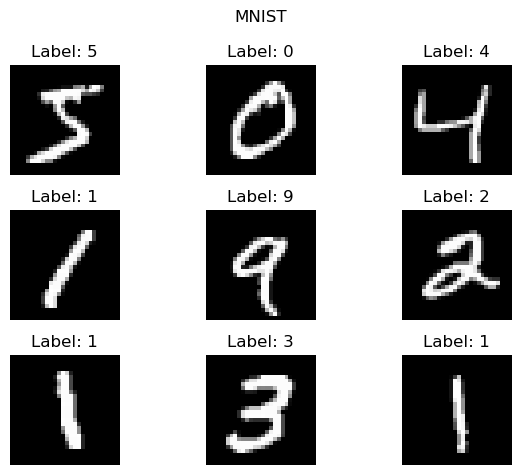

In [11]:
display_nine_images(mnist_trainset)

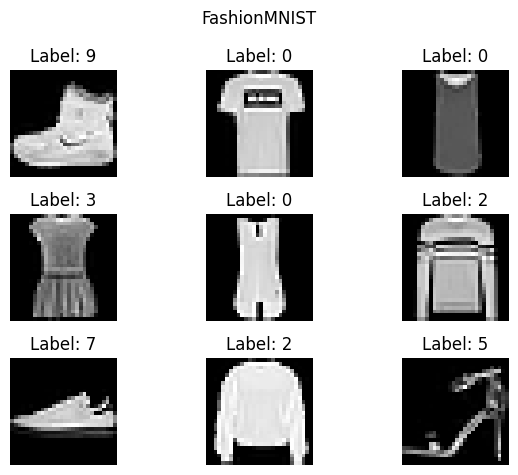

In [5]:
display_nine_images(fashion_mnist_trainset)

**1.** Implemente o algoritmo de $K$-means e aplique-o ao MNIST usando $K=10$ (o número de dígitos no banco de dados) --- inicializando os centroides aleatoriamente ou usando a estratégia do k-means++. Considere também inicializar os centróides como as médias das imagens de cada classe (é possível já que MNIST possui labels). Em geral, imagens similares são agrupadas junto? Plote exemplos de amostras em cada cluster.

Primeiro vamos transformar o conjunto de dados de matrizes para vetores. Em seguida, aleatorizaros centroides e determinar funções para calcular a distância euclidiana e a atualização dos centroides.

In [6]:
train = mnist_trainset.data.numpy()
train = train.reshape(train.shape[0], -1)
train = train

In [11]:
#10 labels
k = 10

#randm initialization centroids
m ,n  = np.shape(train)
centroids = np.empty((k, n))
for i in range(k):
    centroids[i] = train[np.random.choice(range(m))]

    #get close centroid for each data point
def get_closest_centroid(data, centroids):
    distances = np.linalg.norm(data[:, np.newaxis] - centroids, axis=2)
    return np.argmin(distances, axis=1)

#update centroids
def update_centroids(data, closest_centroids):
    novos_centroids = np.empty((k, n))
    for i in range(k):
        novos_centroids[i] = np.mean(data[closest_centroids == i], axis=0)
    return novos_centroids

def kmeans(data, centroids):
    closest_centroids = get_closest_centroid(data, centroids)
    new_centroids = update_centroids(data, closest_centroids)
    while not np.all(centroids == new_centroids):
        centroids = new_centroids
        closest_centroids = get_closest_centroid(data, centroids)
        new_centroids = update_centroids(data, closest_centroids)
    return centroids, closest_centroids

#get common labels for each cluster
def get_labels(closest_centroids, data):
    cluster_labels = {}
    for i in range(k):
        cluster_labels[i] = np.argmax(np.bincount(data[closest_centroids == i]))
    return cluster_labels

def maps_labels(closest_centroids, labels):
    mapped_labels = np.empty_like(closest_centroids)
    for i in range(k):
        mapped_labels[closest_centroids == i] = labels[i]
    return mapped_labels


In [10]:
centroids, closest_centroids = kmeans(train, centroids)

In [12]:
labels = get_labels(closest_centroids, mnist_trainset.targets.numpy())

In [13]:
mapped_labels = maps_labels(closest_centroids, labels)

Para facilitar a identificação de predições corretas e erroneas podemos usar a matriz de confusão. O ideial é que a diagonal principal seja a mais destacada possível, indicando que a maioria das predições estão corretas. Vamos realizar essa visualização diante da nossa base de dados.

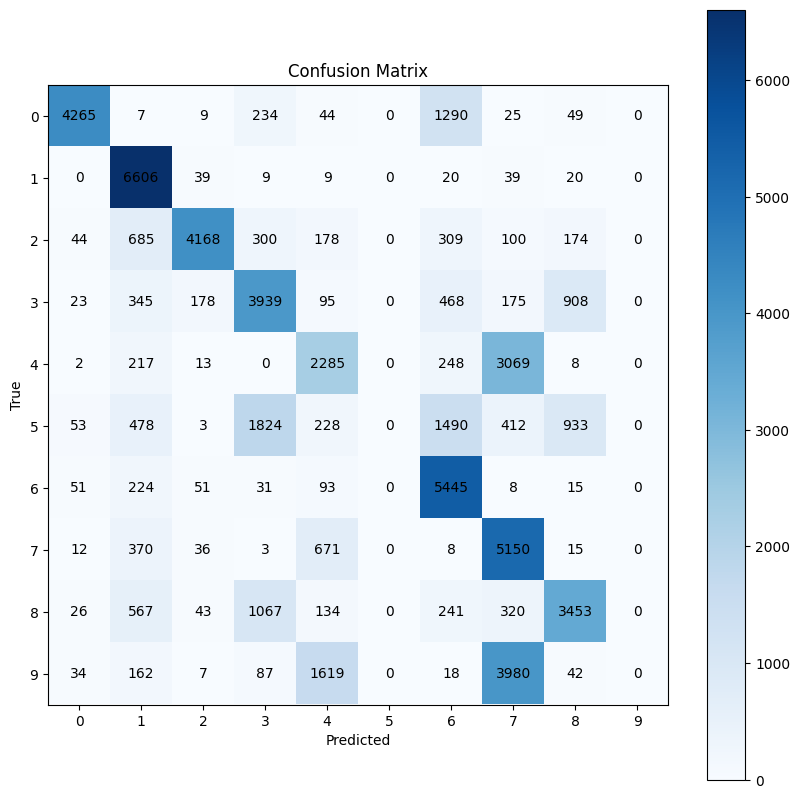

In [16]:
#get confusion matrix
def get_confusion_matrix(true, predicted):
    confusion_matrix = np.zeros((k, k))
    for i in range(k):
        for j in range(k):
            confusion_matrix[i, j] = np.sum((true == i) & (predicted == j))
    return confusion_matrix

confusion_matrix = get_confusion_matrix(mnist_trainset.targets.numpy(), mapped_labels)
#plot confusion matrix
plt.figure(figsize=(10, 10))
plt.imshow(confusion_matrix, cmap='Blues')
#plot numbers in each cell
for i in range(k):
    for j in range(k):
        plt.text(j, i, int(confusion_matrix[i, j]), ha='center', va='center', color='black')
#plot all numbers in eachs axis
plt.xticks(range(k))
plt.yticks(range(k))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.colorbar()

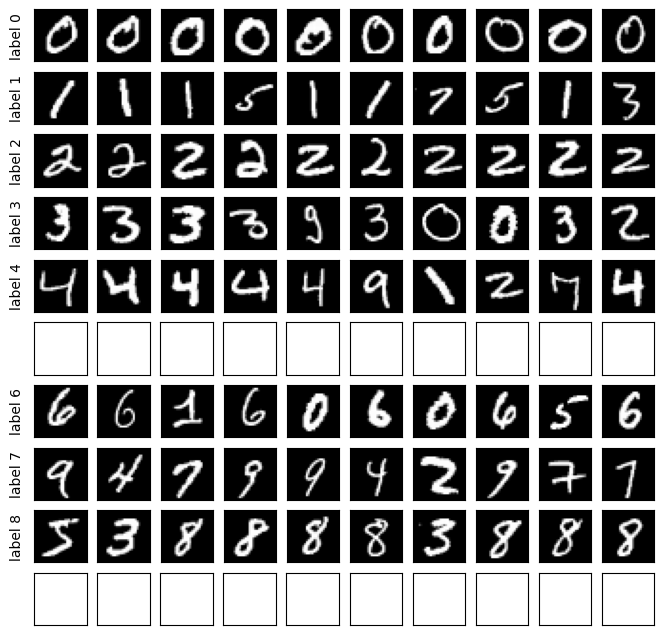

In [20]:
#plot sample of each cluster

def plot_sample(data, mapped_labels):
    fig, ax = plt.subplots(k, 10, figsize=(8, 8))
    for i in range(k):
        for j in range(10):
            if len(data.data[mapped_labels == i]) >= 10:
                ax[i, j].imshow(data.data[mapped_labels == i][j], cmap='gray')
                if j == 0:
                    ax[i, j].set_ylabel(f'label {mapped_labels[mapped_labels == i][j]}')
    plt.setp(ax, xticks=[], yticks=[])
    plt.show()

plot_sample(mnist_trainset, mapped_labels)



Podemos perceber que na maioria das imagens a classificação foi, em maioria, correta. No entanto, os labels 5 e 9 foram os que mais apresentaram erros de classificação, não recebendo nenhuma classificação correta (nem errada). 

Na matriz de confusão é possível ver que tais labels foram distribuídos entre os outros clusters. Na matriz de confusão, os 5's foram distribuídos na maioria pros labels 3 e 6 e os 9's foram nomeados (também em maioria) para os labels 4 e 7.

Na amostra de imagens acima é possível ver que os labels 5 e 9 foram distribuidos entre os outros labels.

Vamos agora reiniciar o processo mas dessa vez ao invés de aleatorizar os centróides vamos inicializá-los com a estratégia do k-means++.

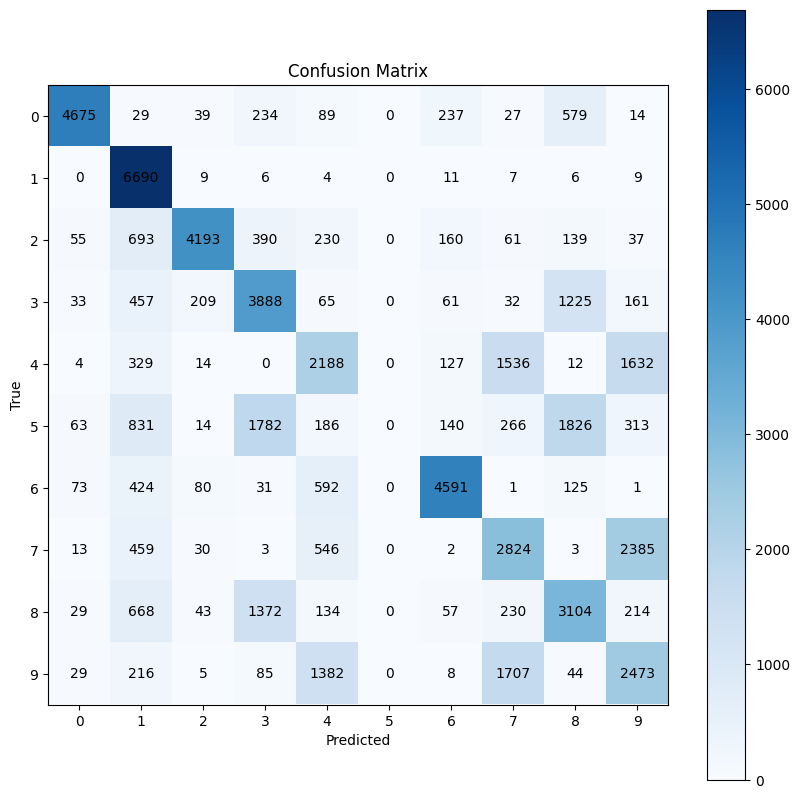

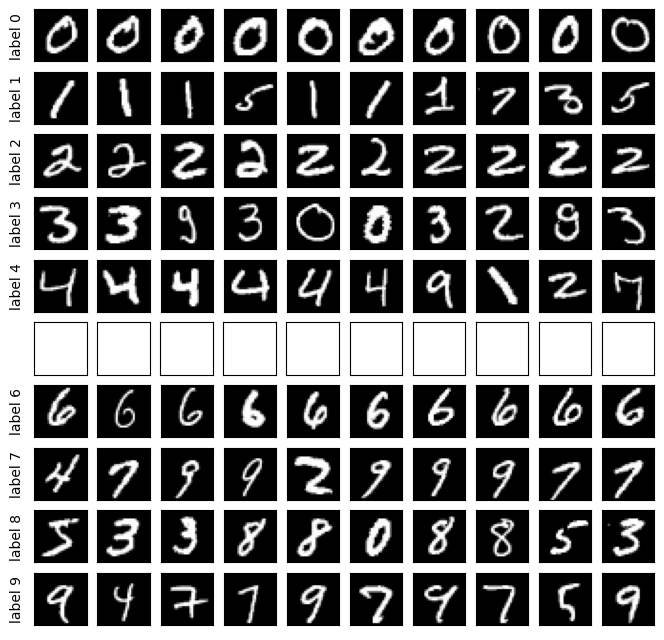

In [21]:
#k-means++ initialization
def kmeans_plus_plus(data, k):
    centroids = np.empty((k, n))
    centroids[0] = data[np.random.choice(range(m))]
    for i in range(1, k):
        distances = np.linalg.norm(data[:, np.newaxis] - centroids[:i], axis=2)
        min_distances = np.min(distances, axis=1)
        probabilities = min_distances / np.sum(min_distances)
        centroids[i] = data[np.random.choice(range(m), p=probabilities)]
    return centroids

centroids = kmeans_plus_plus(train, k)
centroids, closest_centroids = kmeans(train, centroids)
labels = get_labels(closest_centroids, mnist_trainset.targets.numpy())
mapped_labels = maps_labels(closest_centroids, labels)
confusion_matrix = get_confusion_matrix(mnist_trainset.targets.numpy(), mapped_labels)


In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(confusion_matrix, cmap='Blues')
for i in range(k):
    for j in range(k):
        plt.text(j, i, int(confusion_matrix[i, j]), ha='center', va='center', color='black')
plt.xticks(range(k))
plt.yticks(range(k))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.colorbar()
plot_sample(mnist_trainset, mapped_labels)
plt.show()


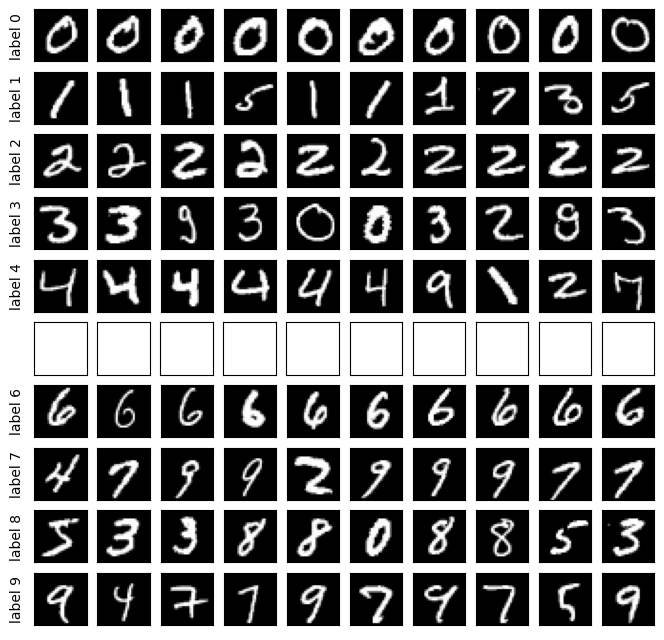

In [22]:
plot_sample(mnist_trainset, mapped_labels)

Podemos notar que o resultado obtido não se distinguil significativamente do obtido anteriormente. A matriz de confusão e a amostra de imagens apresentam resultados similares.

Por fim, vamos reiniciar o processo mas dessa vez ao invés de aleatorizar os centróides vamos inicializá-los com as médias das imagens de cada classe.

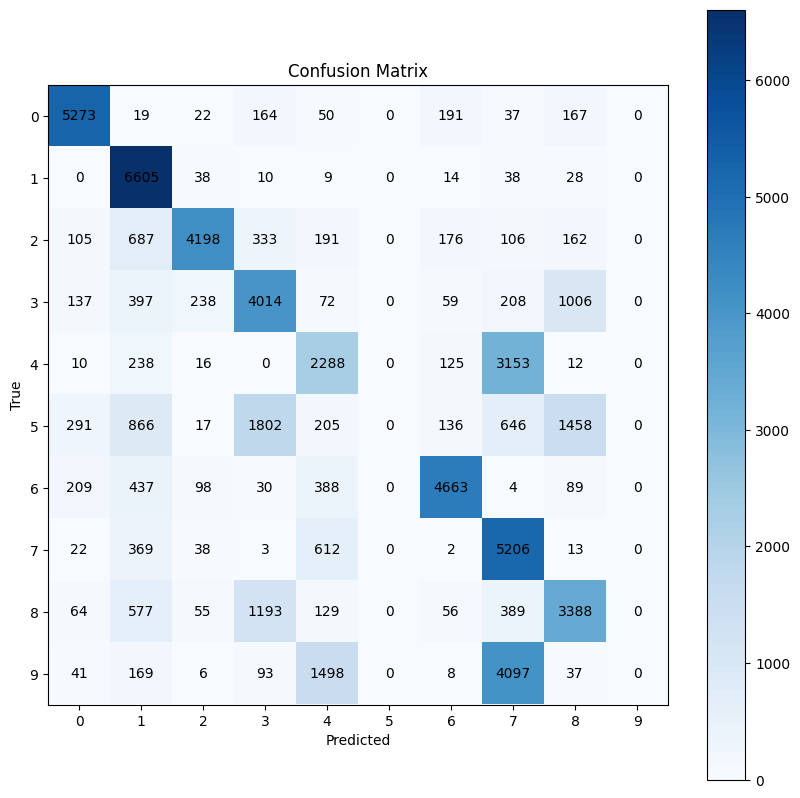

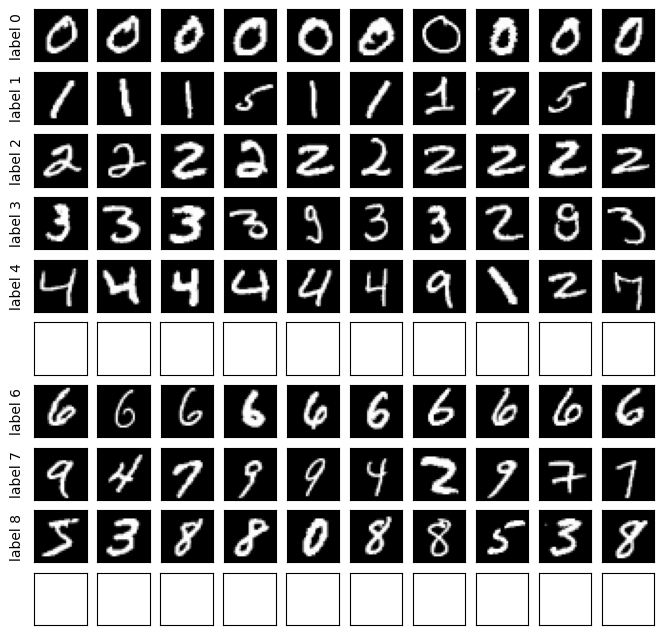

In [23]:
#initialize centroids with average image of each class
centroids = np.empty((k, n))
for i in range(k):
    centroids[i] = np.mean(train[mnist_trainset.targets.numpy() == i], axis=0)
centroids, closest_centroids = kmeans(train, centroids)
labels = get_labels(closest_centroids, mnist_trainset.targets.numpy())
mapped_labels = maps_labels(closest_centroids, labels)
confusion_matrix = get_confusion_matrix(mnist_trainset.targets.numpy(), mapped_labels)
plt.figure(figsize=(10, 10))
plt.imshow(confusion_matrix, cmap='Blues')
for i in range(k):
    for j in range(k):
        plt.text(j, i, int(confusion_matrix[i, j]), ha='center', va='center', color='black')
plt.xticks(range(k))
plt.yticks(range(k))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.colorbar()
plot_sample(mnist_trainset, mapped_labels)
plt.show()

Podemos observar que o resultado não se sobressaiu signifcativamente diante dos demais, afinal 5 e 9 não receberam classificações corretas em nenhum dos casos. Apesar disso, os demais labels tiveram classificações corretas de forma significativa. 

As classificações erradas são justificáveis, dada a variação muito grande no formato dos dígitos e a similaridade entre dígitos diferentes.

**2.** Gaussian Mixture Models (GMMs) são estimadores de densidade poderosos. Podemos utilizá-los, por exemplo, para detectar amostras "fora da distribuição de treino" (out-of-distribution, OOD) em tempo de teste, evitando possíveis previsões catastróficias. Com isso em mente: 
- (a) treine um MLP para classificar o MNIST;
- (b) com o MLP treinado, use um GMM para modelar as ativações da penúltima camada desse MLP (usando as ativações dos dados de treino);
- (c) avalie a capacidade dessa GMM em diferenciar amostras de teste do MNIST e do FashionMNIST (espera-se que amostras OOD --- do FashionMNIST--- estejam nas caudas);
- (d) teste essa estratégia com números diferentes de componente das misturas e escolha a que provê a melhor separação. 

Para simplificar sua vida, use a implementação de GMM do scikit-learn.

In [24]:
train_loader = DataLoader(mnist_trainset, batch_size=100, shuffle=True)
test_loader = DataLoader(mnist_testset, batch_size=100, shuffle=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



In [25]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.l1 = nn.Linear(28*28, 512)
        self.r1 = nn.ReLU()
        self.l2 = nn.Linear(512, 512)
        self.r2 = nn.ReLU()
        #self.l3 = nn.Linear(256, 256)
        #self.r3 = nn.ReLU()
        self.l4 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.l1(x)
        x = self.r1(x)
        x = self.l2(x)
        #x = self.r2(x)
        #x = self.l3(x)
        activation = self.r2(x)
        x = self.l4(activation)
        return x, activation
    
mlp = MLP()

In [30]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001)

def train_epoch(dataloader, model, loss_fn, optimizer):
    global activation
    for X, y in dataloader:
        X = X.to(device)
        y = y.to(device)
        pred, activation = model(X)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

def test(dataloader, model_mlp, model_gmm, threshold):
    global activation_test
    ood_count = 0
    size = len(dataloader.dataset)
    model_mlp.eval()
    correct = 0
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            prediction, activation_test = model_mlp(X)
            loglik = model_gmm.score_samples(np.reshape(activation_test.detach().numpy()[-1], (-1,1)))
            if (loglik < threshold).any():
                ood_count += 1
            correct += (prediction.argmax(1) == y).type(torch.float).sum().item()
    correct /= size
    print(f'Accuracy: {(100*correct):>0.1f}%')
    print(f'OOD: {ood_count}')



In [32]:
epoch = 10
for i in range(epoch):
    train_epoch(train_loader, mlp, loss_fn, optimizer)


In [34]:
gmm = GaussianMixture(10)
act_fit = np.reshape(activation.detach().numpy(), (-1,1))
gmm.fit(act_fit)

threshold = np.min(gmm.score_samples(act_fit))
test(test_loader, mlp, gmm, threshold)


Accuracy: 98.1%
OOD: 2


In [35]:
both_tests = torch.utils.data.ConcatDataset([mnist_testset, fashion_mnist_trainset])
both_loader = DataLoader(both_tests, batch_size=100, shuffle=True)

test(both_loader, mlp, gmm, threshold)

Accuracy: 20.0%
OOD: 35


In [42]:
for i in range(1, 11):
    print(f'Number of components: {i}')
    gmm = GaussianMixture(i)
    act_fit = np.reshape(activation.detach().numpy()[-1], (-1,1))
    gmm.fit(act_fit)
    threshold = np.min(gmm.score_samples(act_fit))
    test(test_loader, mlp, gmm, threshold)
    

Number of components: 1
Accuracy: 98.1%
OOD: 6
Number of components: 2
Accuracy: 98.1%
OOD: 1
Number of components: 3
Accuracy: 98.1%
OOD: 5
Number of components: 4
Accuracy: 98.1%
OOD: 3
Number of components: 5
Accuracy: 98.1%
OOD: 2
Number of components: 6
Accuracy: 98.1%
OOD: 7
Number of components: 7
Accuracy: 98.1%
OOD: 11
Number of components: 8
Accuracy: 98.1%
OOD: 11
Number of components: 9
Accuracy: 98.1%
OOD: 4
Number of components: 10
Accuracy: 98.1%
OOD: 5


In [41]:
fashion_mnist_trainset.targets.shape

torch.Size([60000])

Observe que a melhor separação de amostras OOD foi obtida com 2 componentes, e portanto consideramos essa versão (dentre as testadas), a melhor em separar amostras, já que sabemos que o tamanho do tamanho do conjunto de teste do Fashion MNIST é 60000, e como treinamos apenas no MNIST, quanto mais dessas amostras forem classificadas como out of distribution, melhor.

## Exercício de "papel e caneta"

**1.** Como vimos anteriormente, a função custo para $k$-means é:
\begin{equation}
    \sum_{i=1\ldots K} \sum_{x \in C_i} \| x - \mu_i \|_2^2,
\end{equation}
a qual otimizamos atualizando os clusters e seus respectivos centróides de maneira alternada. Suponha, no entanto, que nosso banco de dados contém entradas faltantes, i.e., existe algum vetor $x=[x_1, \ldots, x_D]$ para o qual apenas as entradas $x_o \forall o(x) \in O(x) \subseteq \{1,\ldots,D\}$ foram observadas. Deixe, similarmente, que $M(x)$ denote o conjunto de índices faltantes em $x$. Existem várias maneiras de contornar esse problema. A mais animalesca (e que descarta menos informação) é jogar fora amostras com entradas faltantes. Pode-se também pré-processar o banco de dados para preencher os valores faltantes. Uma terceira opção é codificar nossa incerteza sobre $x_{M(x)}$ como uma distribuição e propagar essa incerteza pela nossa função custo. Caso não saibamos muito sobre esses valores faltantes, por exemplo, podemos atribuir uma Gaussiana com média zero e variância $c>0$ para cada $x_m \forall m \in M(x)$. Nesse caso, nossa função custo se transforma em: 
\begin{equation}
    \sum_{i=1\ldots K} \sum_{x \in C_i} \mathbb{E}_{x_{M(x)} \sim N\left(0, c I_{|M(x)|}\right)}\big[\| x - \mu_i \|_2^2\big],
\end{equation}

Derive algoritmo para otimizar a função acima --- de maneira similar à que derivamos o $k$-means. Comente como seu algoritmo difere do $K$-means original.



Vamos fazer uma otimizaçção utilizando os passos do algoritmo EM para otimizar a função de custo quando não conhecemos todos os labels. O passo E representa, a partir de um centroide $\mu_i$ a definição de um cluster de pontos, enquanto $M$ é a redefinição de um centroide partindo de um cluster de pontos - vamos chamar esse cluster de $C_i$.

o que faremos é reescrever a função de custo para que ela seja uma função de $\mu_i$ e $C_i$ como uma variável indicatriz $r_{nk}$. Daí 

$$\sum_{n = 1,\dots, N}\sum{k = 1,\dots, K}r_{nk}\mathbb{E}_{x_nM_{(x_n)}\sim N(0,cI_{|M(x_n)})}[||x_n-\mu_k||_2^2]$$

No passo E queremos os pontos que minimizam a distância de cada centróide. Daí usamos 1 para o cluster que minimiza a distância de cada ponto e 0 para os demais.
$$r_{nk} = 1 \text{ se } k = argmin_j||x_n-\mu_j||_2^2 \text{ e } 0 \text{ caso contrário}$$

No passo M queremos redefinir o centróide partindo do fato de que temos um novo cluster de pontos. Vamos derivar nossa função com relação a $\mu_k$ e igualar a zero.
$$\frac{\partial}{\partial \mu_k}\sum_{n = 1,\dots, N}\sum{k = 1,\dots, K}r_{nk}\mathbb{E}_{x_nM_{(x_n)}\sim N(0,cI_{|M(x_n)})}[||x_n-\mu_k||_2^2] = 0$$

$$\sum_{n = 1,\dots, N}r_{nk}\mathbb{E}_{x_nM_{(x_n)}\sim N(0,cI_{|M(x_n)})}[||x_n-\mu_k||_2^2] = 0$$

$$\mu_k = \frac{\sum_{n = 1,\dots, N}r_{nk}\mathbb{E}_{x_nM_{(x_n)}\sim N(0,cI_{|M(x_n)})}[x_n]}{\sum_{n = 1,\dots, N}r_{nk}}$$

Quando aplicamos o operador de esperança de $x_n$ teremos 0 para entradas faltantes, pois a média é 0. 
Com isso, temos uma definição de centroides iniciais que passa pelos passos E e M até convergir. O algoritmo é similar ao K-means, mas com a diferença de que a média é 0 para entradas faltantes. Este é o algoritmo:
1. Defina um centroide inicial $\mu_i$ para cada cluster $C_i$
2. Enquanto não convergir:

    3. Para cada ponto $x_n$ calcule $r_{nk} = 1 \text{ se } k = argmin_j||x_n-\mu_j||_2^2 \text{ e } 0 \text{ caso contrário}$
    4. Para cada cluster $C_i$ calcule $\mu_i = \frac{\sum_{n = 1,\dots, N}r_{nk}x_n}{\sum_{n = 1,\dots, N}r_{nk}}$

É importante ressaltar que como temos entradas faltantes, o algoritmo é ligeiramente diferente do K-means original, pois a média é 0 para entradas faltantes.

Para calcular a distância desses pontos o que fazemos é calcular a esperança das distâncias, considerand a ditribuição de probailidade das entradas faltantes. Além disso, no passo M calculamos a esperança dos pontos para encontrar o novo centroide.

**2.** Na aula, motivamos o uso de _Gaussian Mixture Models_ (GMMs) e discutimos como estimar seus parâmetros via máxima verossimilhança. Mais especificamente, começamos a derivar um algoritmo de _coordinate ascent_ para maximizar a verossimilhança. Siga os passos da Seção 9.2 (página 430) do [_Pattern Recognition and Machine Learning_ (C. Bishop)](https://www.microsoft.com/en-us/research/uploads/prod/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf) e mostre a derivação passo-a-passo (boa parte está omitida no livro) do algoritmo.

Considere a distribuição de mistura de Gaussianas:
$$p(x) = \sum_{k=1}^K \pi_k \mathcal{N}(x|\mu_k, \Sigma_k),$$

onde $\pi_k$ são os pesos das misturas, $\mu_k$ são as médias e $\Sigma_k$ são as matrizes de covariância. A verossimilhança é dada por:

$0 \leq \pi_k \leq 1$ e $\sum_{k=1}^K \pi_k = 1$. Vamos assumir que tivemos N observações e que queremos descorbrir os parâmetros $\pi_k, \mu_k, \Sigma_k$ que maximizam a verossimilhança:

$$p(X|\pi, \mu, \Sigma) = \prod_{n=1}^N p(x_n) = \prod_{n=1}^N \sum_{k=1}^K \pi_k \mathcal{N}(x_n|\mu_k, \Sigma_k).$$

Seja a função de custo C a log-verossimilhança:
$$C(\pi, \mu, \Sigma) = \ln p(X|\pi, \mu, \Sigma) = \sum_{n=1}^N \ln \sum_{k=1}^K \pi_k \mathcal{N}(x_n|\mu_k, \Sigma_k).$$

Seja ainda $r_{nk}$ a responsabilidade que a mistura k tem sobre o ponto n:

$$r_{nk} = \frac{\pi_k \mathcal{N}(x_n|\mu_k, \Sigma_k)}{\sum_{j=1}^K \pi_j \mathcal{N}(x_n|\mu_j, \Sigma_j)}.$$

Para maximizar $C$ usaremos coordenadas alternadas. Primeiro maximizamos com relação a $\pi_k$. Como $\sum_{k=1}^K \pi_k = 1$, usamos multiplicadores de Lagrange para maximizar a função de custo. Derivando com relação a $\pi_k$ e igualando a zero, temos:

$$\sum_{n=1}^N \frac{\mathcal{N}(x_n|\mu_k, \Sigma_k)}{\sum_{j=1}^K \pi_j \mathcal{N}(x_n|\mu_j, \Sigma_j)} + \lambda = 0$$

$$\sum_{n=1}^N \frac{\mathcal{N}(x_n|\mu_k, \Sigma_k)}{\sum_{j=1}^K \pi_j \mathcal{N}(x_n|\mu_j, \Sigma_j)} = \frac{N_k}{\pi_k},$$

$$\frac{N_k}{\pi_k} + \lambda = 0$$

$$\pi_k = -\frac{N_k}{\lambda},$$

Vamos guardar essa equação e derivar com relação aos outros parâmetros para encontrar o valor de $\lambda$.

Derivando agora com relação a $\mu_k$ e igualando a zero, temos:
$$\sum_{n=1}^N r_{nk}\Sigma_k^{-1}(x_n - \mu_k) = 0$$
$$\mu_k = \frac{\sum_{n=1}^N r_{nk}x_n}{\sum_{n=1}^Nr_{nk}}$$


Derivando com relação a $\Sigma_k$ e igualando a zero, temos:

$$\sum_{n=1}^N r_{nk}\left(\Sigma_k^{-1} - \Sigma_k^{-1}(x_n - \mu_k)(x_n - \mu_k)^T\Sigma_k^{-1}\right) = 0$$

$$\Sigma_k = \frac{\sum_{n=1}^N r_{nk}(x_n - \mu_k)(x_n - \mu_k)^T}{\sum_{n=1}^N r_{nk}}$$

Encontrando o valor de $\lambda$ e substituindo na equação de $\pi_k$ temos:
$$\frac{\delta}{\delta \lambda} = 0$$
$$\sum_{k=1}^K \pi_k - 1 = 0$$

Substituindo $\pi_k$ na equação acima temos:
$$\sum_{k=1}^K -\frac{N_k}{\lambda} = 1$$
$$\lambda = -N$$


Substituindo novamente 
$$\mu_k = \frac{\sum_{n=1}^Nr_{nk}x_n}{\sum_{n=1}^Nr_{nk}}$$
$$\Sigma_k = \frac{\sum_{n=1}^N r_{nk}(x_n - \mu_k)(x_n - \mu_k)^T}{\sum_{n=1}^N r_{nk}}$$
$$\pi_k = \frac{\sum_{n=1}^Nr_{nk}}{N}$$
